In [283]:
from pyspark import sql, SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import sum, rank, dense_rank, when, udf
from pyspark.sql.context import SQLContext
import pandas
import os
import matplotlib.pyplot as plt
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from PIL  import Image

def getrows(df, rownums=None):
    return df.rdd.zipWithIndex().filter(lambda x: x[1] in rownums).map(lambda x: x[0])

conf = SparkConf().setAppName("Read_CSV")
sc = SparkContext.getOrCreate(conf=conf)
sqlContext = sql.SQLContext(sc)
sch = StructType([StructField('Index', IntegerType(), True), 
                     StructField('ASIN', StringType(), True), 
                     StructField('overall', LongType(), True), 
                     StructField('reviewText', StringType(), True), 
                     StructField('Date', StringType(), True), 
                     StructField('reviewerID', StringType(), True),
                     StructField('reviewerName', StringType(), True), 
                     StructField('summary', StringType(), True), 
                     StructField('DateTime', LongType(), True),
                     StructField('helpful0', IntegerType(), True),
                     StructField('helpful1', IntegerType(), True),
                     StructField('helpful_ratio', FloatType(), True)])
#x=pandas.io.parsers.read_csv("unicsvfile1.csv",delimiter=u"\uFFFE", chunksize=4, engine="python", header=None)
#df = SparkSession(sc).createDataFrame(data=x,schema=sch)
spk=sql.SQLContext(sc)
ss=sql.SparkSession(sc)
df = sqlContext.read.csv("unicsvfile9.csv", sep=u"\uFFFE", encoding="UTF-8",schema=sch)     #   reviewText    overall    summary    DateTime    reviewTime
df.schema.names
df.printSchema()

root
 |-- Index: integer (nullable = true)
 |-- ASIN: string (nullable = true)
 |-- overall: long (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- DateTime: long (nullable = true)
 |-- helpful0: integer (nullable = true)
 |-- helpful1: integer (nullable = true)
 |-- helpful_ratio: float (nullable = true)



In [207]:
df.groupBy("reviewerID").count().count() #number of unique authors

33206

In [4]:
df.groupBy("ASIN").count().count()#.show()#.count() #number of unique books

824

In [6]:
df.groupBy("reviewerID").count().withColumnRenamed('count', "Number of reviews").show() #number of reviews per user

+--------------+-----------------+
|    reviewerID|Number of reviews|
+--------------+-----------------+
|A140XH16IKR4B0|                2|
|A3QAURNUVCL3P6|                1|
|A3LRQV6XA6F8PO|                6|
|A3GLTWW1UMHK21|                1|
|A1CNQTCRQ35IMM|                6|
|A3R9X003XW0LNR|                6|
|A12DVG1FD6DEQE|                1|
| AYOJ4CX2CZP7Y|                2|
| AMCISVGFXKM1A|                2|
|A1HO5UY9M4VXII|                2|
|A2D6BR8I6KOLSW|                1|
| AYBFMIUC6XBSG|                1|
|A1UYMXFON06KQ6|                9|
|A1712VK3ZT6KW5|                2|
| A6HOWM08PLFZ5|                1|
|A3GHZZM7CNK77I|                1|
|A3OFWAVPZT56UB|                7|
|A2XCUQOGFM6GEH|                1|
|A1RY4HXCQ1SSFT|                3|
|A3MLH5VYUW2RVJ|                2|
+--------------+-----------------+
only showing top 20 rows



In [311]:
df.groupBy("ASIN").count().withColumnRenamed('count', "Number of reviews").show() #number of reviews per product

+----------+-----------------+
|      ASIN|Number of reviews|
+----------+-----------------+
|  62070142|               14|
|  62070770|                9|
|  62075934|               38|
|  62076205|               71|
|  62078194|                9|
|  62080601|               46|
|  62105078|                8|
|  62117378|              210|
|  62073583|               71|
|  62074261|               14|
|  62077988|               11|
|  62100327|               32|
|  62070436|               26|
|  62071041|              291|
|  62073508|              138|
|  62088971|               26|
|006211896X|                5|
|  62133837|               17|
|  62076019|                9|
|  62081934|               48|
+----------+-----------------+
only showing top 20 rows



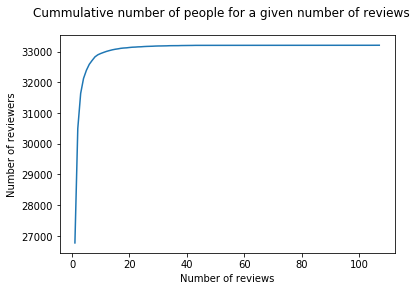

In [284]:
ff=df.groupBy("reviewerID").count().withColumnRenamed('count', "Review_per_user").groupBy("Review_per_user").count().sort("Review_per_user",ascending=True)#.show() #users with given number of review. used for calculating cummulative reviews
spk.registerDataFrameAsTable(df=ff,tableName="reviewdata")
#ss.sql("SELECT * from reviewdata").show()
#windowval = (Window.partitionBy("Review_per_user").orderBy('count').rangeBetween(Window.unboundedPreceding, Window.currentRow))
#ff.sampleData.withColumn("cumulativeSum", sql.functions.sum((ff["count"])).over( Window.partitionBy("Review per user").orderBy("Review per user")))
#ff.withColumn('cum_sum', sql.functions.sum('count').over(windowval))#.show()
temp=ss.sql("select a.Review_per_user, sum(b.count) as cumulative_count from reviewdata a join reviewdata b on a.Review_per_user >= b.Review_per_user group by a.Review_per_user order by a.Review_per_user")
temp1=temp.toPandas().transpose().values.tolist()
plt.figure().suptitle('Cummulative number of people for a given number of reviews')
plt.xlabel("Number of reviews")
plt.ylabel("Number of reviewers")
plt.plot(temp1[0],temp1[1])
plt.savefig('1.png')

In [84]:
df.orderBy(["DateTime"],ascending=0).show()

+------+----------+-------+--------------------+-----------+--------------+--------------------+--------------------+----------+--------+--------+-------------+
| Index|      ASIN|overall|          reviewText|       Date|    reviewerID|        reviewerName|             summary|  DateTime|helpful0|helpful1|helpful_ratio|
+------+----------+-------+--------------------+-----------+--------------+--------------------+--------------------+----------+--------+--------+-------------+
|410655|  62076051|      3|"Synopsis: A rebe...|07 22, 2014|A2TZ0D6K7YK7XH|            Isabella|It could have bee...|1405987200|       0|       0|          0.0|
|444800|006219237X|      3|So, I didn't read...|07 19, 2014|A16YCHWXKL8CAX|This Girl Reads A...|Wicked Games is w...|1405728000|       0|       0|          0.0|
|410666|  62076051|      5|I honestly don't ...|07 18, 2014|A2KN1WNA76HQS6|           TracyJane|Great ending to a...|1405641600|       0|       0|          0.0|
|410664|  62076051|      5|Very ni

In [46]:
temp=df.groupBy("reviewerID").avg("overall").show()

+--------------+------------------+
|    reviewerID|      avg(overall)|
+--------------+------------------+
|A140XH16IKR4B0|               3.0|
|A3QAURNUVCL3P6|               4.0|
|A3LRQV6XA6F8PO| 4.833333333333333|
|A3GLTWW1UMHK21|               4.0|
|A1CNQTCRQ35IMM|2.6666666666666665|
|A3R9X003XW0LNR|3.8333333333333335|
|A12DVG1FD6DEQE|               5.0|
| AYOJ4CX2CZP7Y|               4.5|
| AMCISVGFXKM1A|               3.5|
|A1HO5UY9M4VXII|               5.0|
|A2D6BR8I6KOLSW|               5.0|
| AYBFMIUC6XBSG|               5.0|
|A1UYMXFON06KQ6|3.4444444444444446|
|A1712VK3ZT6KW5|               5.0|
| A6HOWM08PLFZ5|               4.0|
|A3GHZZM7CNK77I|               5.0|
|A3OFWAVPZT56UB|               4.0|
|A2XCUQOGFM6GEH|               4.0|
|A1RY4HXCQ1SSFT|               5.0|
|A3MLH5VYUW2RVJ|               5.0|
+--------------+------------------+
only showing top 20 rows



In [312]:
temp=df.groupBy("ASIN").avg("overall").show()

+----------+------------------+
|      ASIN|      avg(overall)|
+----------+------------------+
|  62070142|3.7857142857142856|
|  62070770| 4.444444444444445|
|  62075934| 4.026315789473684|
|  62076205| 4.549295774647887|
|  62078194| 4.333333333333333|
|  62080601|3.8043478260869565|
|  62105078|             3.875|
|  62117378| 4.504761904761905|
|  62073583| 4.394366197183099|
|  62074261| 4.642857142857143|
|  62077988| 4.090909090909091|
|  62100327|            4.4375|
|  62070436| 4.538461538461538|
|  62071041| 4.144329896907217|
|  62073508| 4.492753623188406|
|  62088971| 4.076923076923077|
|006211896X|               3.2|
|  62133837| 4.764705882352941|
|  62076019| 4.111111111111111|
|  62081934| 4.208333333333333|
+----------+------------------+
only showing top 20 rows



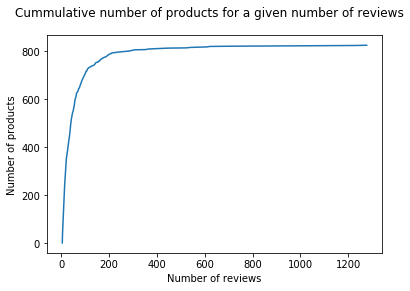

In [285]:
ffff=df.groupBy("ASIN").count().withColumnRenamed('count', "Review_per_user").groupBy("Review_per_user").count().sort("Review_per_user",ascending=True)#.show() #users with given number of review. used for calculating cummulative reviews
spk.registerDataFrameAsTable(df=ffff,tableName="productreviewdata")
#ss.sql("SELECT * from reviewdata").show()
#windowval = (Window.partitionBy("Review_per_user").orderBy('count').rangeBetween(Window.unboundedPreceding, Window.currentRow))
#ff.sampleData.withColumn("cumulativeSum", sql.functions.sum((ff["count"])).over( Window.partitionBy("Review per user").orderBy("Review per user")))
#ff.withColumn('cum_sum', sql.functions.sum('count').over(windowval))#.show()
temp=ss.sql("select a.Review_per_user, sum(b.count) as cumulative_count from productreviewdata a join productreviewdata b on a.Review_per_user >= b.Review_per_user group by a.Review_per_user order by a.Review_per_user")
temp1=temp.toPandas().transpose().values.tolist()
plt.figure().suptitle('Cummulative number of products for a given number of reviews')
plt.xlabel("Number of reviews")
plt.ylabel("Number of products")
plt.plot(temp1[0],temp1[1])
plt.savefig('2.png')

In [95]:
ff=df.groupBy("ASIN").count().withColumnRenamed('count', "Review per user").groupBy("Review per user").count().sort("Review per user",ascending=True).show() #products with given number of review. used for calculating cummulative reviews


+---------------+-----+
|Review per user|count|
+---------------+-----+
|              4|    1|
|              5|   38|
|              6|   20|
|              7|   28|
|              8|   24|
|              9|   24|
|             10|   24|
|             11|   27|
|             12|   23|
|             13|   16|
|             14|   19|
|             15|   16|
|             16|   20|
|             17|   12|
|             18|   23|
|             19|   14|
|             20|   15|
|             21|    8|
|             22|    8|
|             23|    7|
+---------------+-----+
only showing top 20 rows



In [272]:
df.groupBy("reviewerID","DateTime").count().show()

+--------------+----------+-----+
|    reviewerID|  DateTime|count|
+--------------+----------+-----+
| A9DT7GDZGB582|1372809600|    1|
| AG35NEEFCMQVR|1340582400|    1|
|A3JLXAZ2JUG495|1382313600|    1|
| A12PG6RE2PN61|1379894400|    1|
|A1MG7OL46UZNZ8|1341446400|    1|
|A26318FAA8DME1|1360108800|    1|
| AX98HPXDIK2XF|1372204800|    1|
|A3NH1FV748GAA3|1349049600|    1|
| AR6M85K01LFJ7|1366416000|    1|
|A37903KX80ULKG|1338422400|    2|
|A14Q69AX6LQ0Y2|1394409600|    1|
|A10LWBOIZCF2QT|1328745600|    1|
|A2FCLVOW24CCTV|1371427200|    1|
|A1MB1VDDI7IY2A|1380931200|    2|
|A231LBC8EGPO5L|1368489600|    1|
|A1YLYKNFTG7UQV|1338249600|    1|
|A231LBC8EGPO5L|1325548800|    1|
|A13CMG4T0EVF8A|1365206400|    3|
|A1LXKH05CJOFIQ|1329609600|    2|
|A315KKET3LKUQQ|1327449600|    1|
+--------------+----------+-----+
only showing top 20 rows



In [152]:
rating_by_user=1
breakdownbyperson=[]
while(rating_by_user<=5):
    vvv = df.filter(df.overall==rating_by_user).withColumn("rank", rank().over(  Window.partitionBy("reviewerID").orderBy("DateTime")   )).groupBy("rank").sum("overall").sort("rank",ascending=True).limit(200)
    breakdownbyperson.append([vvv,vvv.count()])
    rating_by_user=rating_by_user+1

In [153]:
max = breakdownbyperson[0][1]
for a in breakdownbyperson:
    if(a[1]>max):
        max = a[1]
print("Maximum is "+str(max))
bdp = np.zeros([5,max])
i=0
j=0
k=0
for a in breakdownbyperson: 
    for b in a:
        j=0
        for kkk in a[0].select("sum(overall)").collect():
            bdp[i,j]=kkk['sum(overall)']
            #print(type(kkk['sum(overall)']))
            j=j+1   
    i=i+1
for a in range(0,max):
    bdp[:,a]=(bdp[:,a]*100)/bdp[:,a].sum()
    #print(bdp[:,a])
    
lst=[]
xlst=[]
for a in range(0,max):
    lst.append(bdp[:,a].tolist())
    xlst.append(a)

Maximum is 55


<Figure size 432x288 with 0 Axes>

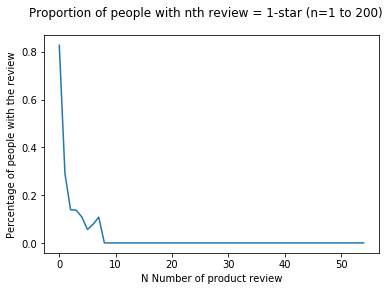

In [300]:
plt.figure()
plt.figure().suptitle('Proportion of people with nth review = 1-star (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of people with the review")
plt.plot(xlst,bdp[0,:])
plt.savefig('3.png')

<Figure size 432x288 with 0 Axes>

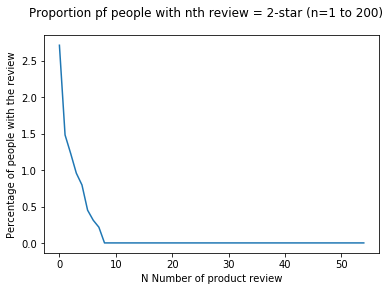

In [301]:
plt.figure()
plt.figure().suptitle('Proportion pf people with nth review = 2-star (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of people with the review")
plt.plot(xlst,bdp[1,:])
plt.savefig('4.png')

<Figure size 432x288 with 0 Axes>

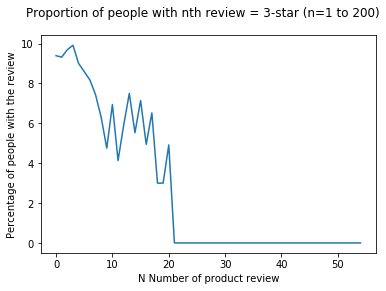

In [302]:
plt.figure()
plt.figure().suptitle('Proportion of people with nth review = 3-star (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of people with the review")
plt.plot(xlst,bdp[2,:])
plt.savefig('5.png')

<Figure size 432x288 with 0 Axes>

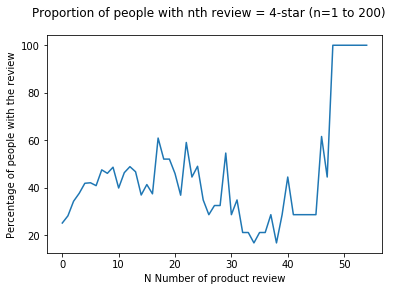

In [303]:
plt.figure()
plt.figure().suptitle('Proportion of people with nth review = 4-star (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of people with the review")
plt.plot(xlst,bdp[3,:])
plt.savefig('6.png')

<Figure size 432x288 with 0 Axes>

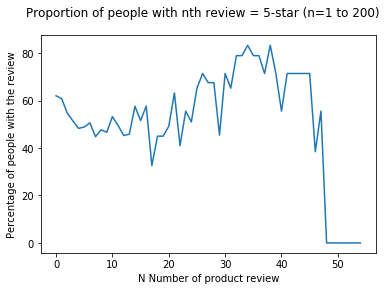

In [304]:
plt.figure()
plt.figure().suptitle('Proportion of people with nth review = 5-star (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of people with the review")
plt.plot(xlst,bdp[4,:])
plt.savefig('7.png')

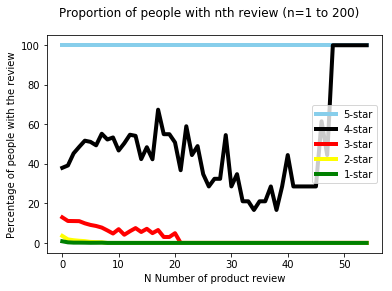

In [293]:
plt.figure().suptitle('Proportion of people with nth review (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of people with the review")
plt.plot(xlst,bdp[4,:] + bdp[3,:] + bdp[2,:] + bdp[1,:] + bdp[0,:], markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot(xlst,bdp[3,:] + bdp[2,:] + bdp[1,:] + bdp[0,:], markerfacecolor='black', markersize=12, color='black', linewidth=4)
plt.plot(xlst,bdp[2,:] + bdp[1,:] + bdp[0,:], markerfacecolor='red', markersize=12, color='red', linewidth=4)
plt.plot(xlst,bdp[1,:] + bdp[0,:], markerfacecolor='yellow', markersize=12, color='yellow', linewidth=4)
plt.plot(xlst,bdp[0,:], markerfacecolor='green', markersize=12, color='green', linewidth=4)
#plt.legend((bdp[4,:],bdp[3,:],bdp[2,:],bdp[1,:],bdp[0,:]),("5-star","4-star","3-star","2-star","1-star"))
plt.legend(["5-star","4-star","3-star","2-star","1-star"])
plt.savefig('8.png')

In [160]:
rating_by_user=1
breakdownbyproduct=[]
while(rating_by_user<=5):
    www = df.filter(df.overall==rating_by_user).withColumn("rank", rank().over(  Window.partitionBy("ASIN").orderBy("DateTime")   )).groupBy("rank").sum("overall").sort("rank",ascending=True).limit(200)
    breakdownbyproduct.append([www,www.count()])
    rating_by_user=rating_by_user+1
max = breakdownbyproduct[0][1]
for a in breakdownbyproduct:
    if(a[1]>max):
        max = a[1]
print("Maximum is "+str(max))
bdpr = np.zeros([5,max])
i=0
j=0
k=0
for a in breakdownbyproduct: 
    for b in a:
        j=0
        for uuu in a[0].select("sum(overall)").collect():
            bdpr[i,j]=uuu['sum(overall)']
            #print(type(kkk['sum(overall)']))
            j=j+1   
    i=i+1
for a in range(0,max):
    bdpr[:,a]=(bdpr[:,a]*100)/bdpr[:,a].sum()
    #print(bdp[:,a])
    
lst2=[]
xlst2=[]
for a in range(0,max):
    lst2.append(bdpr[:,a].tolist())
    xlst2.append(a)    


Maximum is 200


<Figure size 432x288 with 0 Axes>

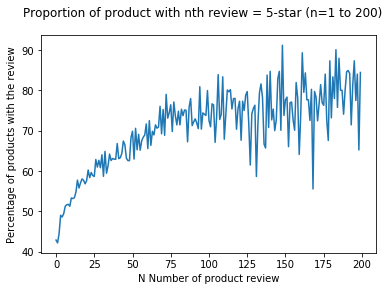

In [305]:
plt.figure()
plt.figure().suptitle('Proportion of product with nth review = 5-star (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of products with the review")
plt.plot(xlst2,bdpr[4,:])
plt.savefig('9.png')

<Figure size 432x288 with 0 Axes>

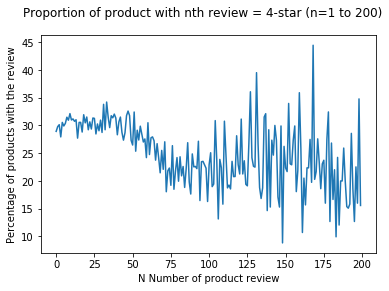

In [306]:
plt.figure()
plt.figure().suptitle('Proportion of product with nth review = 4-star (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of products with the review")
plt.plot(xlst2,bdpr[3,:])
plt.savefig('10.png')

<Figure size 432x288 with 0 Axes>

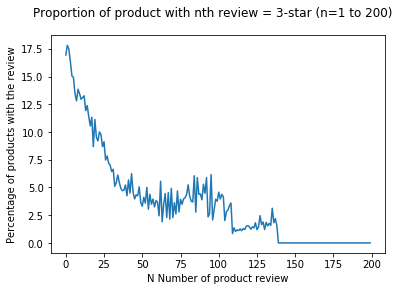

In [307]:
plt.figure()
plt.figure().suptitle('Proportion of product with nth review = 3-star (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of products with the review")
plt.plot(xlst2,bdpr[2,:])
plt.savefig('11.png')

<Figure size 432x288 with 0 Axes>

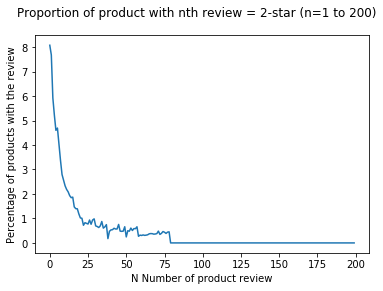

In [308]:
plt.figure()
plt.figure().suptitle('Proportion of product with nth review = 2-star (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of products with the review")
plt.plot(xlst2,bdpr[1,:])
plt.savefig('12.png')

<Figure size 432x288 with 0 Axes>

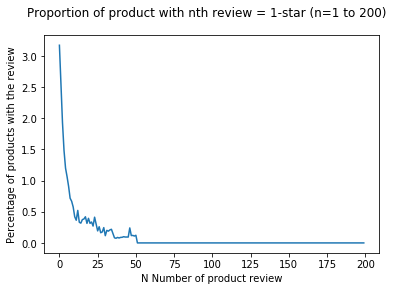

In [309]:
plt.figure()
plt.figure().suptitle('Proportion of product with nth review = 1-star (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of products with the review")
plt.plot(xlst2,bdpr[0,:])
plt.savefig('13.png')

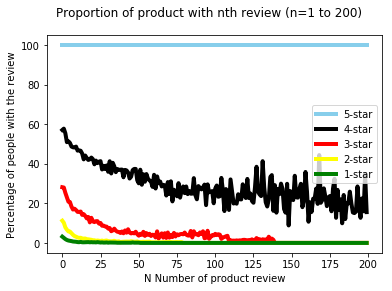

In [310]:
plt.figure().suptitle('Proportion of product with nth review (n=1 to 200)')
plt.xlabel("N Number of product review")
plt.ylabel("Percentage of people with the review")
plt.plot(xlst2,bdpr[4,:] + bdpr[3,:] + bdpr[2,:] + bdpr[1,:] + bdpr[0,:], markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot(xlst2,bdpr[3,:] + bdpr[2,:] + bdpr[1,:] + bdpr[0,:], markerfacecolor='black', markersize=12, color='black', linewidth=4)
plt.plot(xlst2,bdpr[2,:] + bdpr[1,:] + bdpr[0,:], markerfacecolor='red', markersize=12, color='red', linewidth=4)
plt.plot(xlst2,bdpr[1,:] + bdpr[0,:], markerfacecolor='yellow', markersize=12, color='yellow', linewidth=4)
plt.plot(xlst2,bdpr[0,:], markerfacecolor='green', markersize=12, color='green', linewidth=4)
#plt.legend((bdp[4,:],bdp[3,:],bdp[2,:],bdp[1,:],bdp[0,:]),("5-star","4-star","3-star","2-star","1-star"))
plt.legend(["5-star","4-star","3-star","2-star","1-star"])
plt.savefig('14.png')

In [280]:
sid = SentimentIntensityAnalyzer()
negsentiment = udf(lambda x: sid.polarity_scores(x)['neg'], FloatType())
possentiment = udf(lambda x: sid.polarity_scores(x)['pos'], FloatType())
neusentiment = udf(lambda x: sid.polarity_scores(x)['neu'], FloatType())
tempdf = df.select('ASIN','reviewerID','DateTime', negsentiment('reviewText').alias('negative'), possentiment('reviewText').alias('positive'), neusentiment('reviewText').alias('neutral'))
tempdf.show()

+--------+--------------+----------+--------+--------+-------+
|    ASIN|    reviewerID|  DateTime|negative|positive|neutral|
+--------+--------------+----------+--------+--------+-------+
|62067753|A3P971UDN6C8JK|1340668800|   0.023|   0.076|  0.901|
|62067753| AK3K3AJXDU6B5|1342569600|   0.133|   0.128|  0.739|
|62067753|A1S1JLW3OJIR69|1383264000|   0.043|   0.169|  0.788|
|62067753|A1KC2HS8VAEX9K|1345507200|   0.056|   0.165|  0.779|
|62067753|A1NLTQLKMKNV88|1356912000|     0.0|   0.212|  0.788|
|62067753|A16I0WIMKWDS2H|1343260800|   0.023|   0.139|  0.838|
|62067753|A2JMYDV1SS32Y9|1383091200|   0.047|    0.35|  0.603|
|62067753|   AFVQZQ8PW0L|1340064000|   0.039|   0.086|  0.876|
|62067753|A1RIV04HAYRV62|1355011200|   0.047|   0.142|  0.811|
|62067753|A25NFVQ40463A1|1394064000|     0.0|   0.135|  0.865|
|62067753|A1CR1AJMVPUCM0|1380758400|     0.0|   0.175|  0.825|
|62067753|A22M4X1AWZMIDK|1388620800|   0.016|   0.089|  0.895|
|62067753|A2309Y0FL5Q14L|1403308800|   0.101|   0.094| 